<h1 style='font-size: 35px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>Impact of Fertilizers on Maize Growth and Yield</h1>


---

<h2 style='font-family: Colonna MT; font-weight: 600; font-size: 20px; text-align: left'>1.0. Import Required Libraries</h2>

In [1]:
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
from itertools import combinations
from statsmodels.formula.api import ols as smf_ols # Alternative import for working with OLS
from scipy.stats import shapiro, levene, skew, kurtosis, zscore
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import string
import math
import re

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Libraries Loaded Successfully")

Libraries Loaded Successfully


<h2 style='font-family: Colonna MT; font-weight: 600; font-size: 20px; text-align: left'>2.0. Import and Preprocessing Dataset</h2>

In [2]:
filepath = 'Datasets/Fertilizer and Light Exposure Experiment Dataset.csv'
df = pd.read_csv(filepath)
df.sample(10)

,Fertilizer,Light Exposure,Plant Height (cm),Leaf Area (cm²),Chlorophyll Content (SPAD units),Root Length (cm),Biomass (g),Flower Count (number),Seed Yield (g),Stomatal Conductance (mmol/m²/s)
116,Organic,Partial Shade,63.56,179.53,35.55,26.30,10.47,16.11,6.17,234.22
102,Control,Partial Shade,53.62,160.80,38.28,25.02,9.15,16.60,5.75,220.20
96,Organic,Partial Shade,64.65,185.95,39.39,25.73,11.25,22.32,6.44,269.80
56,Control,Full Shade,40.18,145.09,30.72,18.95,8.97,14.01,4.51,179.56
63,Synthetic,Full Sun,66.18,229.27,45.00,29.32,17.30,19.51,9.49,280.09
40,Organic,Full Shade,53.57,146.25,30.95,16.58,7.23,14.80,5.24,215.72
61,Organic,Full Shade,49.14,139.72,37.03,19.40,11.39,15.53,5.32,200.38
62,Synthetic,Partial Shade,60.41,208.83,51.09,27.38,9.70,19.66,7.03,280.20
22,Synthetic,Partial Shade,69.44,189.29,50.59,26.53,13.27,18.59,7.03,258.17
1,Organic,Full Shade,46.70,138.80,34.69,17.66,8.67,15.37,6.17,233.66


<h2 style='font-family: Colonna MT; font-weight: 600; font-size: 20px; text-align: left'>3.0. Dataset Informations/ Overview</h2>

In [63]:
df.shape

(120, 7)

In [3]:
df.columns

Index(['Fertilizer', 'Light Exposure', 'Plant Height (cm)', 'Leaf Area (cm²)',
       'Chlorophyll Content (SPAD units)', 'Root Length (cm)', 'Biomass (g)',
       'Flower Count (number)', 'Seed Yield (g)',
       'Stomatal Conductance (mmol/m²/s)'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fertilizer                        120 non-null    object 
 1   Light Exposure                    120 non-null    object 
 2   Plant Height (cm)                 120 non-null    float64
 3   Leaf Area (cm²)                   120 non-null    float64
 4   Chlorophyll Content (SPAD units)  120 non-null    float64
 5   Root Length (cm)                  120 non-null    float64
 6   Biomass (g)                       120 non-null    float64
 7   Flower Count (number)             120 non-null    float64
 8   Seed Yield (g)                    120 non-null    float64
 9   Stomatal Conductance (mmol/m²/s)  120 non-null    float64
dtypes: float64(8), object(2)
memory usage: 9.5+ KB


<h4 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>3.1: Columns Summary</h4>

To begin the analysis, it is important to explore the dataset by summarizing its structure and key attributes. This involves examining the **data types (dtypes)** of each column to determine whether they contain numerical or categorical values, which helps in selecting appropriate analytical techniques. Additionally, checking the **number of unique values** in each column provides insight into the variability of the data, distinguishing between continuous and discrete features.  

Assessing **distinct values** allows for a better understanding of the diversity within each variable, while identifying **missing values** is essential to evaluate data completeness and potential gaps that may require handling. Lastly, reviewing the **count of non-null entries** ensures the dataset’s integrity and helps in deciding whether any preprocessing steps, such as data imputation or cleaning, are necessary. This exploratory step lays the foundation for effective analysis and meaningful insights.

In [5]:
def column_summary(df):
    summary_data = []
    
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df


summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Fertilizer,object,0,120,3,"{'Control': 41, 'Synthetic': 40, 'Organic': 39}"
1,Light Exposure,object,0,120,3,"{'Full Shade': 44, 'Full Sun': 40, 'Partial Sh..."
2,Plant Height (cm),float64,0,120,120,"{58.56151388665052: 1, 46.696826238466286: 1, ..."
3,Leaf Area (cm²),float64,0,120,120,"{185.73856643236132: 1, 138.7980608962804: 1, ..."
4,Chlorophyll Content (SPAD units),float64,0,120,120,"{46.5196207922374: 1, 34.69363266870892: 1, 40..."
5,Root Length (cm),float64,0,120,120,"{24.31891050096943: 1, 17.6585349528435: 1, 26..."
6,Biomass (g),float64,0,120,120,"{11.994074041165357: 1, 8.667791843721698: 1, ..."
7,Flower Count (number),float64,0,120,120,"{19.53594616947752: 1, 15.366158832462084: 1, ..."
8,Seed Yield (g),float64,0,120,120,"{6.687959618540082: 1, 6.165373569255893: 1, 5..."
9,Stomatal Conductance (mmol/m²/s),float64,0,120,120,"{242.41380014645895: 1, 233.65862057163417: 1,..."


<h4 style='font-size: 18px; color: Blue; font-family: Colonna MT; font-weight: 600'>3.2: Checking Missing Values</h4>

Checking for missing values is a crucial step in data analysis to assess the completeness and reliability of the dataset. This involves identifying any columns with null or empty entries, which may affect the accuracy of statistical and machine learning models. Missing values can arise due to various reasons, such as incomplete survey responses or data collection errors.

In [6]:
def Missig_values_info(df):   
    isna_df = df.isna().sum().reset_index(name='Missing Values Counts')
    isna_df['Proportions (%)'] = isna_df['Missing Values Counts']/len(df)*100
    return isna_df
    
isna_df = Missig_values_info(df)
isna_df

,index,Missing Values Counts,Proportions (%)
0,Fertilizer,0,0.00
1,Light Exposure,0,0.00
2,Plant Height (cm),0,0.00
3,Leaf Area (cm²),0,0.00
4,Chlorophyll Content (SPAD units),0,0.00
5,Root Length (cm),0,0.00
6,Biomass (g),0,0.00
7,Flower Count (number),0,0.00
8,Seed Yield (g),0,0.00
9,Stomatal Conductance (mmol/m²/s),0,0.00


<h4 style='font-size:18px; color: Blue; font-family: Colonna MT; font-weight: 600'>3.4: Renaming Columns</h4>

When working with data, especially in statistical tests like ANOVA, column names with special characters or spaces can cause errors. To avoid this, we can clean the column names by converting them to lowercase, replacing any special characters (such as punctuation) with underscores, and ensuring there are no spaces. This makes the column names consistent and compatible with most analysis functions, preventing errors during data processing. The renaming process is automatic, making it easy to handle datasets with potentially problematic column names.

In [7]:
def rename(text):
    text = re.sub(r'[^a-zA-Z]', "",  text) 
    return text

test_df = df.copy()
test_df = test_df.rename(columns={col: rename(col) for col in test_df.columns})
print("\n Columns names before renaming\n")
print(df.columns)
print("\n Columns names after renaming\n")
print(test_df.columns)


 Columns names before renaming

Index(['Fertilizer', 'Light Exposure', 'Plant Height (cm)', 'Leaf Area (cm²)',
       'Chlorophyll Content (SPAD units)', 'Root Length (cm)', 'Biomass (g)',
       'Flower Count (number)', 'Seed Yield (g)',
       'Stomatal Conductance (mmol/m²/s)'],
      dtype='object')

 Columns names after renaming

Index(['Fertilizer', 'LightExposure', 'PlantHeightcm', 'LeafAreacm',
       'ChlorophyllContentSPADunits', 'RootLengthcm', 'Biomassg',
       'FlowerCountnumber', 'SeedYieldg', 'StomatalConductancemmolms'],
      dtype='object')


<h1 style='font-size: 25px; font-family: Colonna MT; font-weight: 600'>4.0: Statistic Description of The Datasets</h1>

Let's take a moment to quickly explore some essential statistics of our dataset. By using the `describe()` function in pandas, we can generate a summary of key metrics for each numerical column in the dataset. This gives us a bird's-eye view of the data, helping us understand the general distribution and characteristics of the values.

In [8]:
Summary_stats = df.describe().T.reset_index()
Summary_stats.rename(columns={'index': 'Variables'}, inplace=True)
Summary_stats = Summary_stats.round(2)
Summary_stats

,Variables,count,mean,std,min,25%,50%,75%,max
0,Plant Height (cm),120.00,60.58,14.93,35.89,46.82,60.18,69.33,95.14
1,Leaf Area (cm²),120.00,181.90,45.93,108.65,142.32,180.71,205.00,312.30
2,Chlorophyll Content (SPAD units),120.00,42.03,9.86,23.99,34.58,40.37,48.66,73.21
3,Root Length (cm),120.00,23.86,5.44,14.75,19.01,23.64,27.07,39.40
4,Biomass (g),120.00,11.97,2.89,7.23,9.63,11.45,13.87,19.61
5,Flower Count (number),120.00,18.18,4.43,10.57,14.80,17.64,21.08,30.03
6,Seed Yield (g),120.00,6.16,1.49,3.86,4.94,6.14,7.03,10.16
7,Stomatal Conductance (mmol/m²/s),120.00,241.68,55.74,148.69,192.69,240.25,276.74,383.45


<h4 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>4.2:  Distribution of Continuous variables</h4>

Let's explore the distribution of continuous variables by examining key statistics. The **Mean** represents the average value, while the **Median** offers a more robust measure against outliers. The **Mode** identifies the most frequent value. **Standard Deviation** and **Variance** indicate how much data deviates from the mean, with larger values showing greater spread. The **Range** highlights the difference between the maximum and minimum values. **Skewness** measures distribution symmetry, and **Kurtosis** reveals the presence of outliers by analyzing the distribution's "tailedness." These metrics provide a comprehensive view of data distribution and help identify potential issues.

In [9]:
def compute_overall_distribution_stats(df):
    results = []
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else np.nan
        std_dev = df[col].std()
        variance = df[col].var()
        value_range = df[col].max() - df[col].min()
        skewness_val = skew(df[col], nan_policy='omit')  # Skewness
        kurtosis_val = kurtosis(df[col], nan_policy='omit')  # Kurtosis

        results.append({
            'Parameter': col,
            'Mean': mean,
            'Median': median,
            'Mode': mode,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Range': value_range,
            'Skewness': skewness_val,
            'Kurtosis': kurtosis_val
        })

    
    result_df = pd.DataFrame(results)
    return result_df

Results = compute_overall_distribution_stats(df)
Results

,Parameter,Mean,Median,Mode,Standard Deviation,Variance,Range,Skewness,Kurtosis
0,Plant Height (cm),60.58,60.18,35.89,14.93,222.90,59.26,0.37,-0.73
1,Leaf Area (cm²),181.90,180.71,108.65,45.93,2109.99,203.66,0.56,-0.32
2,Chlorophyll Content (SPAD units),42.03,40.37,23.99,9.86,97.29,49.22,0.59,-0.17
3,Root Length (cm),23.86,23.64,14.75,5.44,29.55,24.65,0.62,-0.22
4,Biomass (g),11.97,11.45,7.23,2.89,8.33,12.38,0.60,-0.48
5,Flower Count (number),18.18,17.64,10.57,4.43,19.60,19.45,0.62,-0.26
6,Seed Yield (g),6.16,6.14,3.86,1.49,2.21,6.30,0.50,-0.51
7,Stomatal Conductance (mmol/m²/s),241.68,240.25,148.69,55.74,3106.48,234.76,0.41,-0.58


<h4 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>4.3: Comparatives Analysis</h4>

***Comparing the Means of all the Variables of Interest Across Different Specified Groups***

Now, let's shift our focus to comparing the means of variables across different groups to understand how each behaves within specific categories. This comparison helps identify  differences between groups, revealing patterns or trends that might otherwise go unnoticed. By analyzing these mean comparisons, we gain valuable insights into the relationships between variables and groups, guiding further analysis or decision-making.

In [10]:
def summary_stats(df, Metrics, group=None):
    df_without_location = df.drop(columns=[group])
    grand_mean = df_without_location[Metrics].mean()
    sem = df_without_location[Metrics].sem()
    cv = df_without_location[Metrics].std() / df_without_location[Metrics].mean() * 100
    grouped = df.groupby(group)[Metrics].agg(['mean', 'sem']).reset_index()
    
    summary_df = pd.DataFrame()
    for col in Metrics:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )
    
    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()
    
    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row
    
    return summary_df

Metrics = df.select_dtypes(include=np.number).columns.tolist()
Results = summary_stats(df, Metrics, group='Fertilizer')
Results.T

,0,1,2,3,4,5
Fertilizer,Control,Organic,Synthetic,Grand Mean,SEM,%CV
Plant Height (cm),54.55 ± 1.58,65.61 ± 2.69,61.84 ± 2.42,60.58,1.36,24.65
Leaf Area (cm²),167.76 ± 4.32,194.26 ± 8.37,184.36 ± 8.09,181.90,4.19,25.25
Chlorophyll Content (SPAD units),39.76 ± 1.12,44.85 ± 1.77,41.60 ± 1.67,42.03,0.90,23.47
Root Length (cm),21.97 ± 0.58,25.15 ± 1.03,24.53 ± 0.86,23.86,0.50,22.78
Biomass (g),10.91 ± 0.26,12.56 ± 0.47,12.48 ± 0.56,11.97,0.26,24.12
Flower Count (number),17.13 ± 0.48,19.36 ± 0.82,18.12 ± 0.75,18.18,0.40,24.35
Seed Yield (g),5.68 ± 0.17,6.41 ± 0.26,6.43 ± 0.25,6.16,0.14,24.13
Stomatal Conductance (mmol/m²/s),221.38 ± 6.67,256.74 ± 9.06,247.81 ± 9.74,241.68,5.09,23.06


<h4 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>4.4: Distributions of Categorical Variables</h4>

Now, let's explore the counts and proportions of categorical variables in our dataset, both individually and across groups. Counts show how many times each category appears, giving insight into the distribution of data within each variable. Proportions reveal the relative frequency of each category, helping us understand the balance or imbalance in the data. By examining these across different groups, we can uncover patterns or relationships that are important for further analysis, aiding in a better understanding of the structure and distribution of categorical variables.

In [11]:
def Distributions_of_Categorical_Variables(df, categories):
    data = []
    for category in categories:
        counts = df[category].value_counts()
        proportions = df[category].value_counts(normalize=True)
        for value, count in counts.items():
            proportion = proportions[value]
            data.append({
                'Category': category,
                'Sub-category': value,
                'Count': count,
                'Proportion': f"{proportion:.2%}" 
            })
    
    result_df = pd.DataFrame(data)
    return result_df
categorical_variables = df.select_dtypes(include=['object']).columns
Results = Distributions_of_Categorical_Variables(df, categorical_variables)
Results.head(10)

,Category,Sub-category,Count,Proportion
0,Fertilizer,Control,41,34.17%
1,Fertilizer,Synthetic,40,33.33%
2,Fertilizer,Organic,39,32.50%
3,Light Exposure,Full Shade,44,36.67%
4,Light Exposure,Full Sun,40,33.33%
5,Light Exposure,Partial Shade,36,30.00%


<h1 style='font-size: 25px; font-family: Colonna MT; font-weight: 600'>5.0: Exploration of Data Distribution (Visualizations)</h1>

To gain more intuitive insights, let's explore the data distribution through visualizations. Visual tools like histograms, box plots, and scatter plots help us easily identify patterns, trends, and outliers in the data. These visuals provide a clear representation of how data is spread across variables, allowing for quicker interpretation and a deeper understanding of the dataset’s structure and relationships.

<H4 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>5.1: Histogram (Frequency Distributions)</H4>

Let's start with a histogram to visualize the data distribution. A histogram will display the frequency of data points within specified intervals or bins, helping us understand the shape, spread, and central tendency of the data. By examining the histogram, we can quickly identify patterns such as skewness, the presence of outliers, or whether the data follows a normal distribution. This visualization is a great starting point for exploring the overall distribution of continuous variables.

In [12]:
Metrics = df.select_dtypes(include=[np.number]).columns
Metrics

Index(['Plant Height (cm)', 'Leaf Area (cm²)',
       'Chlorophyll Content (SPAD units)', 'Root Length (cm)', 'Biomass (g)',
       'Flower Count (number)', 'Seed Yield (g)',
       'Stomatal Conductance (mmol/m²/s)'],
      dtype='object')

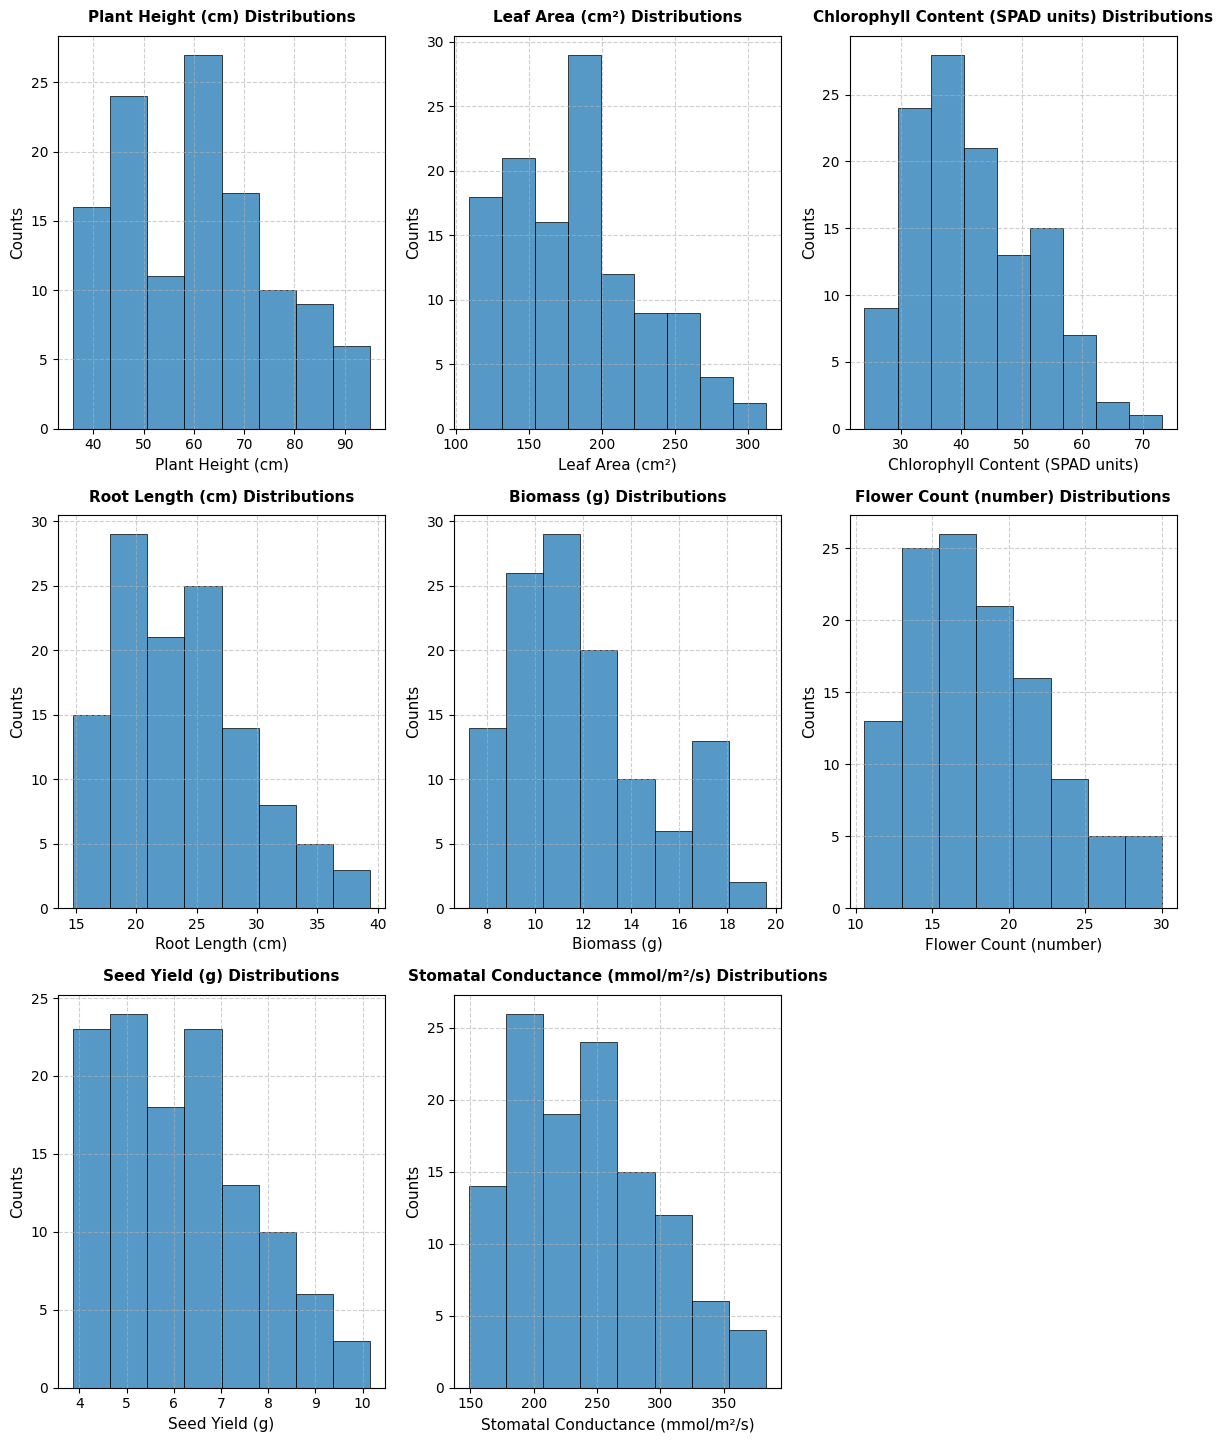

In [13]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 3)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 5*rows))
plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
axes = axes.flatten() if num_variables > 1 else [axes]

for idx, column in enumerate(Metrics):
    sns.histplot(data=df, x=df[column], fill=True, ax=axes[idx], linewidth=0.5)   
    axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].set_ylabel('Counts', fontsize=11)
    axes[idx].grid(linestyle='--', alpha=0.6)

for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

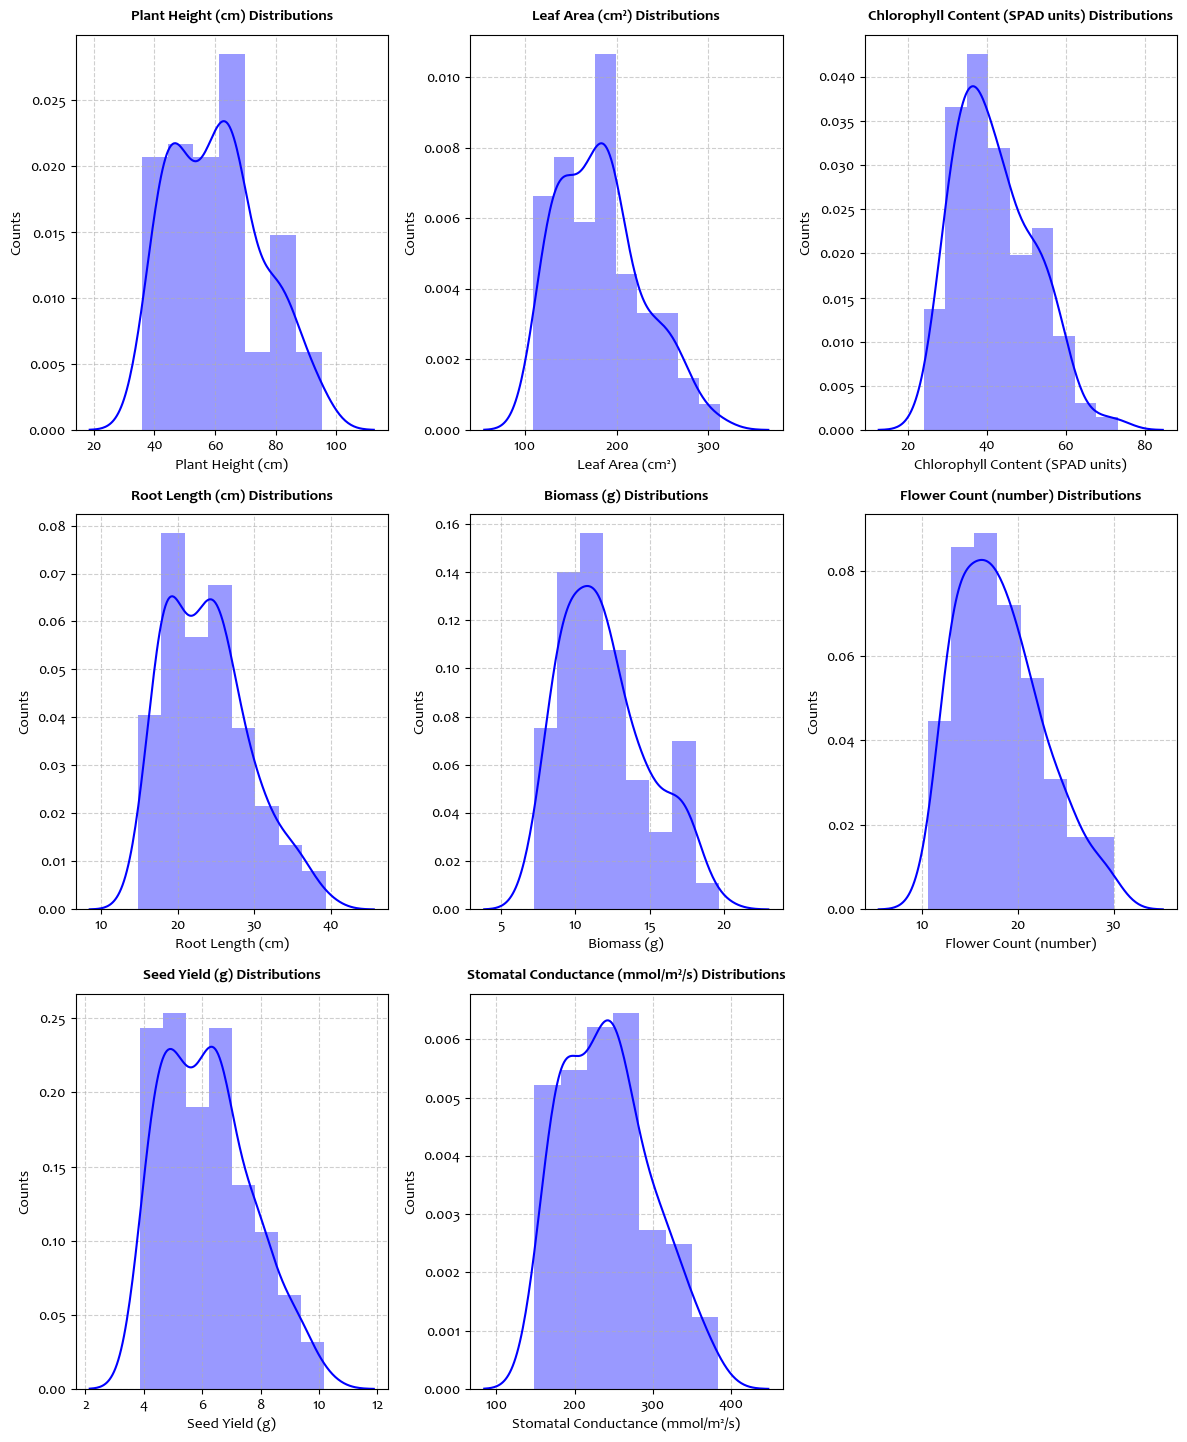

In [14]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 3)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 5 * rows))
plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
axes = axes.flatten() if num_variables > 1 else [axes]

for idx, column in enumerate(Metrics):
    sns.distplot(df[column], kde=True, ax=axes[idx], color='blue')   
    axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].set_ylabel('Counts', fontsize=11)
    axes[idx].grid(linestyle='--', alpha=0.6)

for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<h4 style='font-size: 20px; color: blue; font-family: Colonna MT; font-weight: 600'>5.2: Boxplot (Distributions Comparisons, and Outlier Detections)</h4>

Let's dive into a boxplot to explore outliers and the data distribution across groups. A boxplot visually represents the median, quartiles, and potential outliers in the data. It highlights the spread of the data and shows how values are distributed across groups. Outliers appear as individual points outside the "whiskers" of the boxplot, making it easy to identify any extreme values. By comparing boxplots across different groups, we can also observe how the data varies and if there are significant differences between group distributions. This visualization helps in understanding both central tendencies and variability within the dataset.

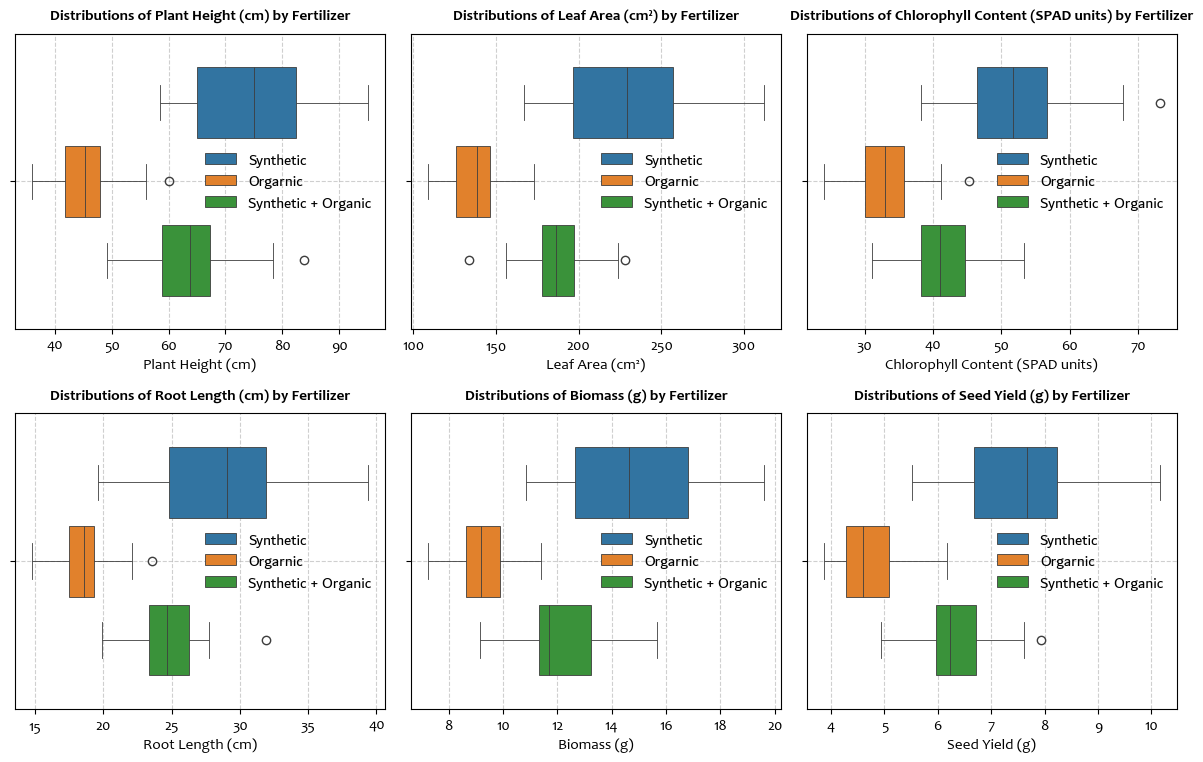

In [76]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 3)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
axes = axes.flatten() if num_variables > 1 else [axes]

for idx, column in enumerate(Metrics):
    sns.boxplot(data=df, x=df[column], fill=True, gap=0.1, ax=axes[idx], hue ='Fertilizer', linewidth=0.6)   
    axes[idx].set_title(f"Distributions of {column} by Fertilizer", fontsize=11, pad=10, fontweight='bold')
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].grid(linestyle='--', alpha=0.6)
    axes[idx].legend(frameon=False)
    

for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<h4 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>5.3. Kernel Density Estimate (KDE) Plot</h4>

Let's use a Kernel Density Estimate (KDE) plot to get a smoother distribution of the data. The KDE plot provides a continuous, smoothed version of the data distribution, which helps us better understand the underlying patterns and density of the data. Unlike histograms, which bin data into discrete intervals, KDE estimates the probability density function, giving us a clearer view of the distribution, identifying peaks, and allowing for easier comparison between variables or groups. This plot is especially useful for visualizing the shape of the data and detecting any subtle trends or differences that may not be as apparent in other visualizations.

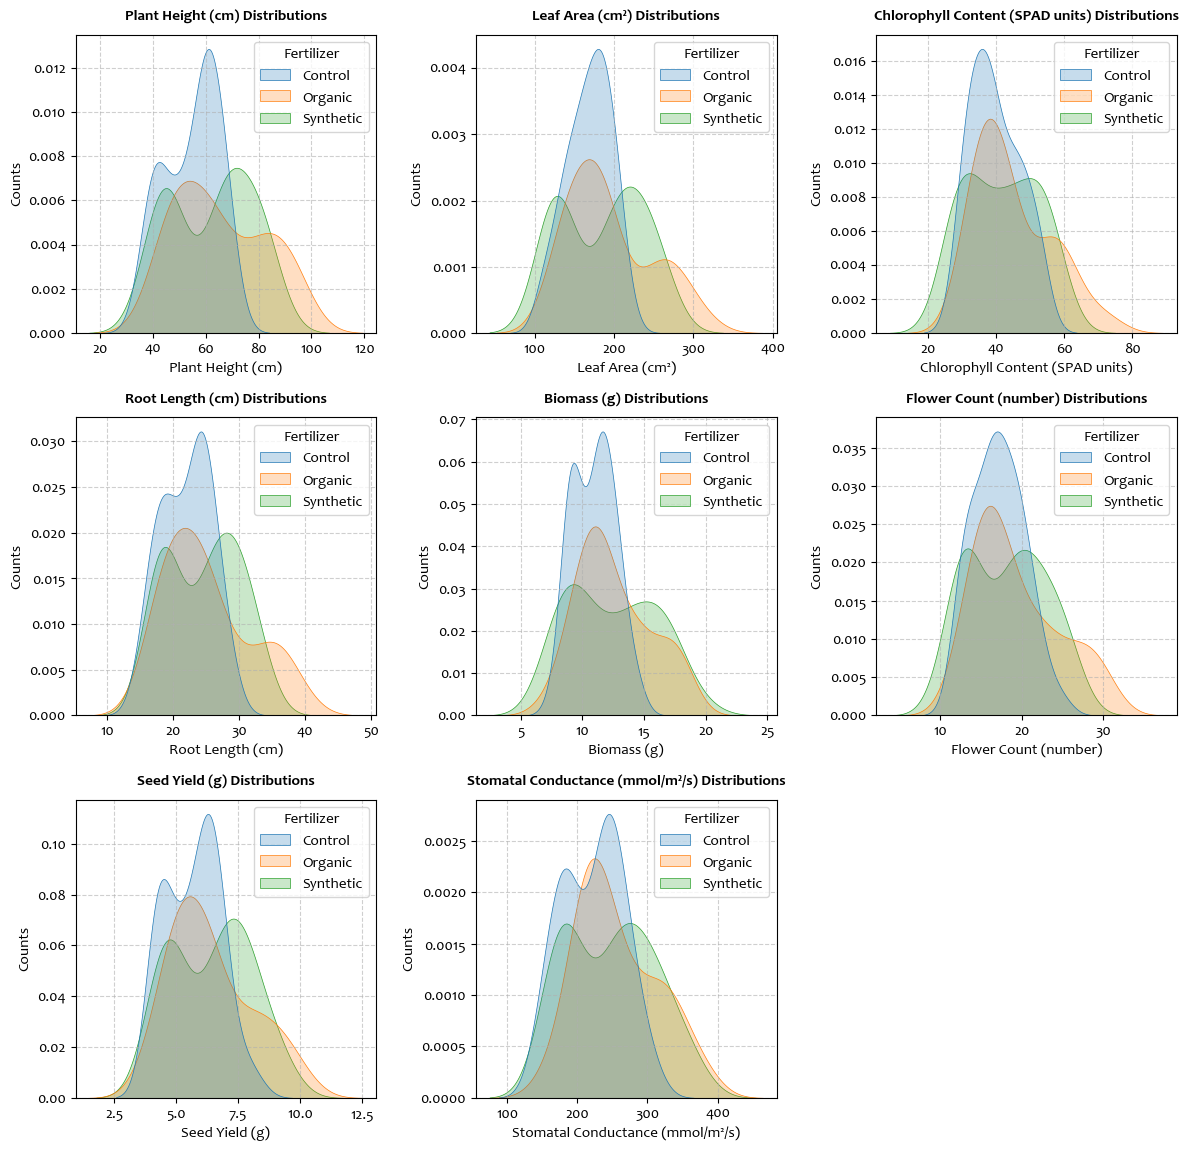

In [15]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 3)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4* rows))
plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
axes = axes.flatten() if num_variables > 1 else [axes]

for idx, column in enumerate(Metrics):
    sns.kdeplot(data=df, x=df[column], fill=True, hue='Fertilizer', ax=axes[idx], linewidth=0.5)   
    axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].set_ylabel('Counts', fontsize=11)
    axes[idx].grid(linestyle='--', alpha=0.6)

for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<h1 style='font-size: 20px; font-family: Colonna MT; font-weight: 600'>6.0: Parametictic Test Assumption Validation</h1>

<H4 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>6.1: Homogeneity of Variance (Homoskedasticity)</H4>

Levene’s Test is a statistical method used to assess **homogeneity of variance (homoskedasticity)**, a key assumption in analyses like **ANOVA**. It tests whether the variances of different groups are equal, with a p-value greater than 0.05 indicating that the assumption holds. If violated, alternative approaches like **Welch's ANOVA** or data transformation may be necessary to ensure reliable results. This test helps maintain the integrity of statistical analysis by confirming whether ANOVA is appropriate for a given dataset.

In [16]:
def Levene_test(df, group_cols, numeric_cols=None): 
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        for g in group_cols:
            if g in numeric_cols:
                numeric_cols.remove(g)
    
    results = []
    for group_col in group_cols:
        for col in numeric_cols:
            grouped_data = [g[col].dropna().values for _, g in df.groupby(group_col)]
            if all(len(g) > 1 for g in grouped_data):  # Ensure each group has enough data
                levene_stat, levene_p = levene(*grouped_data)
                #interpretation = 'Homoscedasticity' if levene_p > 0.05 else 'Heteroscedasticity'
                interpretation = '✔' if levene_p > 0.05 else '✖'
                
            else:
                levene_stat, levene_p, interpretation = None, None, 'Insufficient data'
            
            results.append({
                'Group Column': group_col,
                'Variable': col,
                'Test Statistic': levene_stat,
                'P-Value': levene_p,
                'Interpretation': interpretation
            })
    
    return pd.DataFrame(results)

# Example usage
result_df = Levene_test(df, group_cols=['Fertilizer'])
display(result_df)

,Group Column,Variable,Test Statistic,P-Value,Interpretation
0,Fertilizer,Plant Height (cm),5.40,0.01,✖
1,Fertilizer,Leaf Area (cm²),7.77,0.00,✖
2,Fertilizer,Chlorophyll Content (SPAD units),3.92,0.02,✖
3,Fertilizer,Root Length (cm),4.07,0.02,✖
4,Fertilizer,Biomass (g),11.78,0.00,✖
5,Fertilizer,Flower Count (number),4.62,0.01,✖
6,Fertilizer,Seed Yield (g),3.21,0.04,✖
7,Fertilizer,Stomatal Conductance (mmol/m²/s),2.58,0.08,✔


<h3 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>6.2: Normal Distribution (Normality Test)</h3>

- In statistical analysis, assessing whether data follows a normal distribution is a critical preliminary step, particularly before applying parametric tests such as ANOVA or t-tests. The assumption of normality underpins the reliability of these tests, as violations can lead to misleading results and incorrect conclusions. To evaluate this, normality tests are employed to determine if the distribution of a dataset aligns closely with a theoretical normal distribution. By verifying this assumption, analysts can decide whether the data is suitable for parametric testing or if alternative methods, such as data transformation or non-parametric tests, are more appropriate.

- In the context of our analysis, we utilize the **Shapiro-Wilk test** to examine normality, especially given its effectiveness with small to moderately sized samples. This test compares the order statistics of the observed data against a normal distribution and yields both a **W statistic** and a **p-value**. A **p-value greater than 0.05** indicates that we fail to reject the null hypothesis, suggesting the data is normally distributed. Conversely, a **p-value less than 0.05** implies that the data significantly deviates from normality.

- To strengthen this approach, we incorporate the Central Limit Theorem (CLT) through **bootstrapping**, where appropriate. By repeatedly sampling from the data and calculating the means of these samples, we approximate a sampling distribution of the mean. When bootstrapping is enabled, the Shapiro-Wilk test is applied to this distribution of sample means rather than the raw data. This helps determine whether the distribution of means — rather than individual observations — approximates normality, aligning with the assumptions of inferential statistics based on the CLT. If bootstrapping is disabled, the Shapiro-Wilk test is applied directly to the original dataset, offering a more traditional view of the data's normality. This dual approach provides flexibility and robustness in assessing the suitability of the data for further statistical analysis.


In [17]:
def bootstrapping(df, column, num_samples=1000, sample_size=30):
    sample_means = []
    for _ in range(num_samples):
        sample = df[column].dropna().sample(n=sample_size, replace=True)
        sample_means.append(sample.mean())
    return sample_means

def shapiro_wilk_test(df, group_col, numeric_cols=None, use_bootstrap=True, num_samples=1000, sample_size=30): 
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        if group_col in numeric_cols:
            numeric_cols.remove(group_col)
    
    results = []
    for group, group_df in df.groupby(group_col):
        for col in numeric_cols:
            if use_bootstrap: data = bootstrapping(group_df, col, num_samples=num_samples, sample_size=sample_size)
            else:
                data = group_df[col].dropna()
                
            if len(data) >= 3:  # Shapiro requires at least 3 values
                stat, p_value = shapiro(data)
                interpretation = 'Normal' if p_value > 0.05 else 'Not Normal'
            else:
                stat, p_value, interpretation = None, None, 'Insufficient data'
            
            results.append({
                'Group': group,
                'Variable': col,
                'Test Statistic': stat,
                'P-Value': p_value,
                'Interpretation': interpretation,
                'Used Bootstrap': use_bootstrap
            })
        
    results_df = pd.DataFrame(results)
    return results_df

result_df = shapiro_wilk_test(df, group_col='Fertilizer', use_bootstrap=True)
display(result_df)

,Group,Variable,Test Statistic,P-Value,Interpretation,Used Bootstrap
0,Control,Plant Height (cm),1.00,0.48,Normal,True
1,Control,Leaf Area (cm²),1.00,0.78,Normal,True
2,Control,Chlorophyll Content (SPAD units),1.00,0.04,Not Normal,True
3,Control,Root Length (cm),1.00,0.28,Normal,True
4,Control,Biomass (g),1.00,0.22,Normal,True
5,Control,Flower Count (number),1.00,0.99,Normal,True
6,Control,Seed Yield (g),1.00,0.05,Not Normal,True
7,Control,Stomatal Conductance (mmol/m²/s),1.00,0.65,Normal,True
8,Organic,Plant Height (cm),1.00,0.62,Normal,True
9,Organic,Leaf Area (cm²),1.00,0.78,Normal,True


<h1 style='font-family: Colonna MT; font-weight: 600; font-size: 25px; text-align: left'>7.0. Independent T-test (Pair-Wise Comparison)</h1>

<h3 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>7.1: Effects of Fertilizer on Plant Growth and Yield (kg/ha)</h3>

In [18]:
def Independent_ttest(df, group_column, Variables):
    unique_groups = df[group_column].unique()
    group_combinations = list(combinations(unique_groups, 2))
    results = []
    for column in Variables:
        for group1, group2 in group_combinations:
            group1_data = df[df[group_column] == group1][column]
            group2_data = df[df[group_column] == group2][column]
            t_stat, p_value = ttest_ind(group1_data, group2_data, equal_var=False)
            
            results.append({
                'Parameter': column,
                'Group 1': group1,
                'Group 2': group2,
                'T-Statistic': t_stat,
                'P-Value': p_value,
                'Significance': '✔' if p_value < 0.05 else '✖'
            })
        
    results_df = pd.DataFrame(results)
    return results_df

Metrics = df.select_dtypes(include=[np.number]).columns
Results = Independent_ttest(df, group_column='Fertilizer', Variables=Metrics)
Results

,Parameter,Group 1,Group 2,T-Statistic,P-Value,Significance
0,Plant Height (cm),Control,Organic,-3.54,0.00,✔
1,Plant Height (cm),Control,Synthetic,-2.52,0.01,✔
2,Plant Height (cm),Organic,Synthetic,1.04,0.30,✖
3,Leaf Area (cm²),Control,Organic,-2.81,0.01,✔
4,Leaf Area (cm²),Control,Synthetic,-1.81,0.08,✖
5,Leaf Area (cm²),Organic,Synthetic,0.85,0.40,✖
6,Chlorophyll Content (SPAD units),Control,Organic,-2.44,0.02,✔
7,Chlorophyll Content (SPAD units),Control,Synthetic,-0.91,0.36,✖
8,Chlorophyll Content (SPAD units),Organic,Synthetic,1.34,0.18,✖
9,Root Length (cm),Control,Organic,-2.68,0.01,✔


<h1 style='font-family: Colonna MT; font-weight: 600; font-size: 20px; text-align: left'>8.0. Analysis of Varience (ANOVA)</h1>

<h4 style='font-size: 18px; color: Blue; font-family: Colonna MT; font-weight: 600'>8.1: Analysis of Varience (One Way ANOVA)</h4>

A **one-way ANOVA** (Analysis of Variance) is a statistical test used to determine if there are significant differences between the means of three or more independent groups based on a single factor (or independent variable). It assesses whether the factor has an effect on the dependent variable. If the p-value from the test is less than a specified significance level (usually 0.05), it suggests that at least one group mean is significantly different from the others. The test assumes that the data is normally distributed, the variances are equal across groups (homogeneity of variance), and the observations are independent.

In [19]:
def One_way_anova(data, Metrics, group_cols):
    results = []
    group_cols = [rename(col) for col in group_cols]
    data = data.rename(columns={col: rename(col) for col in data.columns})
    for group in group_cols:
        for col in Metrics:
            column_name = rename(col)  
            formula = f"{column_name} ~ C({group})" 
            model = smf.ols(formula, data=data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            for source, row in anova_table.iterrows():
                p_value = row["PR(>F)"]
                interpretation = "✔" if p_value < 0.05 else "✖"
                if source == "Residual": interpretation = "-"
        
                results.append({
                    "Variable": col,
                    "Factor": group.title(),
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Significance": interpretation
                })

    return pd.DataFrame(results)

group_cols = ["Fertilizer"]
Anova_results = One_way_anova(df, Metrics, group_cols)
Anova_results

,Variable,Factor,Source,Sum Sq,df,F-Value,p-Value,Significance
0,Plant Height (cm),Fertilizer,C(Fertilizer),2540.40,2.00,6.20,0.00,✔
1,Plant Height (cm),Fertilizer,Residual,23984.47,117.00,NaN,NaN,-
2,Leaf Area (cm²),Fertilizer,C(Fertilizer),14394.90,2.00,3.56,0.03,✔
3,Leaf Area (cm²),Fertilizer,Residual,236693.54,117.00,NaN,NaN,-
4,Chlorophyll Content (SPAD units),Fertilizer,C(Fertilizer),529.81,2.00,2.81,0.06,✖
5,Chlorophyll Content (SPAD units),Fertilizer,Residual,11047.89,117.00,NaN,NaN,-
6,Root Length (cm),Fertilizer,C(Fertilizer),229.57,2.00,4.09,0.02,✔
7,Root Length (cm),Fertilizer,Residual,3286.71,117.00,NaN,NaN,-
8,Biomass (g),Fertilizer,C(Fertilizer),70.05,2.00,4.45,0.01,✔
9,Biomass (g),Fertilizer,Residual,921.36,117.00,NaN,NaN,-


<h4 style='font-size: 18px; color: Blue; font-family: Colonna MT; font-weight: 600'>8.2: Welch's ANOVA (Welch's F test)</h4>

Welch's ANOVA (often called Welch's F test) is a statistical test used to compare the means of three or more groups when the assumption of equal variances (homoscedasticity) among the groups is violated. It is an adaptation of the traditional one-way ANOVA that is more robust in the presence of heteroscedasticity (unequal variances) and unequal sample sizes.

In [20]:
def welchs_anova(data, Metrics, group_cols):
    results = []
    
    group_cols = [rename(col) for col in group_cols]
    data = data.rename(columns={col: rename(col) for col in data.columns})
    for group in group_cols:
        for col in Metrics:
            column_name = rename(col)
            
            # Perform Welch's ANOVA using pingouin
            aov = pg.welch_anova(data=data, dv=column_name, between=group)
            
            for _, row in aov.iterrows():
                p_value = row["p-unc"]
                interpretation = "✔" if p_value < 0.05 else "✖"
                results.append({
                    "Variable": col,
                    "Grouping Factor": group.title(),
                    "Source": row["Source"],
                    "df": row["ddof1"],  # Degrees of freedom between groups
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Significance": interpretation
                })

    return pd.DataFrame(results)

group_cols = ["Fertilizer"]
Metrics = df.select_dtypes(include=["float64", "int64"]).columns
welch_results = welchs_anova(df, Metrics, group_cols)
welch_results

,Variable,Grouping Factor,Source,df,F-Value,p-Value,Significance
0,Plant Height (cm),Fertilizer,Fertilizer,2,7.50,0.00,✔
1,Leaf Area (cm²),Fertilizer,Fertilizer,2,4.67,0.01,✔
2,Chlorophyll Content (SPAD units),Fertilizer,Fertilizer,2,2.96,0.06,✖
3,Root Length (cm),Fertilizer,Fertilizer,2,5.16,0.01,✔
4,Biomass (g),Fertilizer,Fertilizer,2,6.57,0.00,✔
5,Flower Count (number),Fertilizer,Fertilizer,2,2.87,0.06,✖
6,Seed Yield (g),Fertilizer,Fertilizer,2,4.40,0.02,✔
7,Stomatal Conductance (mmol/m²/s),Fertilizer,Fertilizer,2,5.69,0.01,✔


<h1 style='font-size: 25px; font-family: Colonna MT; font-weight: 600'>9.0: Post hoc analysis</h1>

**Post hoc analysis** is conducted after a significant ANOVA result to determine which specific group differences are driving the overall significance. Since ANOVA only tells us that at least one group mean is different but not which groups differ, post hoc tests like **Tukey's HSD**, **Bonferroni correction**, and **Dunnett’s test** help identify pairwise differences while controlling for multiple comparisons. These tests ensure that conclusions drawn from the analysis are statistically valid and help in understanding the specific relationships between groups.


***Tukey's Honest Significant Difference (THSD)***

Now, let's perform **Tukey’s Honest Significant Difference (THSD) test** to determine which groups are statistically similar or different. While **ANOVA** tells us if there is a significant difference among groups, it does not specify **which** groups differ. **Tukey’s HSD** helps by comparing all possible group pairs and assigning statistical significance to their differences. This step is crucial in identifying which groups share similarities and which ones are distinct, allowing for a more detailed interpretation of the results.

In [21]:
def Turkey_results(df, group=''):
    results_data = []
    for metric in Metrics:
        turkey_results = pairwise_tukeyhsd(endog=df[metric], groups=df[group], alpha=0.05)
        results_table = turkey_results.summary()
        
        for i in range(1, len(results_table)):
            row = results_table.data[i]
            results_data.append({
                'Metric': metric,
                'Group1': row[0],
                'Group2': row[1],
                'Mean Difference': row[2],
                'P-Value': row[3],
                'Lower CI': row[4],
                'Upper CI': row[5],
                'Reject Null': row[6]
            })
        
        result_df = pd.DataFrame(results_data)
    return result_df

<h3 style='font-size: 18px; color: blue; font-family: Colonna MT; font-weight: 600'>9.1: Effects of Fertilizer on Plant Growth and Yield (kg/ha)</h3>


In [22]:
Turkeyresults = Turkey_results(df, group='Fertilizer')
pd.set_option("display.float_format", "{:.3f}".format)
Turkeyresults

,Metric,Group1,Group2,Mean Difference,P-Value,Lower CI,Upper CI,Reject Null
0,Plant Height (cm),Control,Organic,11.060,0.002,3.458,18.663,True
1,Plant Height (cm),Control,Synthetic,7.283,0.061,-0.271,14.837,False
2,Plant Height (cm),Organic,Synthetic,-3.777,0.472,-11.426,3.872,False
3,Leaf Area (cm²),Control,Organic,26.497,0.026,2.614,50.380,True
4,Leaf Area (cm²),Control,Synthetic,16.602,0.225,-7.127,40.331,False
5,Leaf Area (cm²),Organic,Synthetic,-9.895,0.593,-33.923,14.133,False
6,Chlorophyll Content (SPAD units),Control,Organic,5.094,0.054,-0.065,10.254,False
7,Chlorophyll Content (SPAD units),Control,Synthetic,1.839,0.672,-3.287,6.966,False
8,Chlorophyll Content (SPAD units),Organic,Synthetic,-3.255,0.300,-8.446,1.936,False
9,Root Length (cm),Control,Organic,3.183,0.022,0.369,5.998,True


<h3 style='font-size: 20px; color: Blue; font-family: Colonna Mt; font-weight: 600'>9.2: Tukey's Honest Significant Difference (THSD) Visualizations</h3>

Now, let's visualize Tukey’s Honest Significant Difference (THSD) test results to determine which groups are statistically similar or different. ANOVA indicates if there are overall significant differences, but Tukey’s HSD helps pinpoint which specific groups vary. By plotting the results, we can clearly see confidence intervals for each treatment group and easily interpret whether their means significantly differ.

In [23]:
def plot_tukey_hsd(df, Metrics, title, factor_column, ):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 2)
    cols = min(num_variables, 3)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 10})
    fig.suptitle(f"{title}", fontsize=12, fontweight='bold')
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, column in enumerate(Metrics):
        tukey_result = pairwise_tukeyhsd(df[column], df[factor_column], alpha=0.05)
        tukey_result.plot_simultaneous(ax=axes[idx])
    
        axes[idx].set_title(f"{column}", fontsize=11, pad=10, fontweight='bold')
        axes[idx].set_xlabel("Mean Difference", fontsize=11)
        axes[idx].set_ylabel(factor_column, fontsize=11)
        axes[idx].grid(linestyle="--", alpha=0.6)

    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

***Effects of Fertilizer on Plant Growth and Yield (kg/ha)***

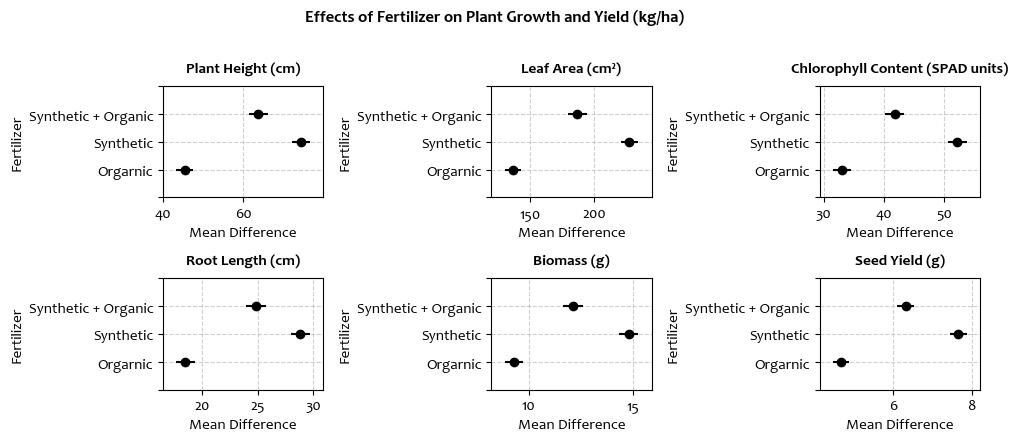

In [53]:
title = "Effects of Fertilizer on Plant Growth and Yield (kg/ha)"
Metrics = df.select_dtypes(include=np.number).columns.tolist()
plot_tukey_hsd(df, Metrics, title, factor_column='Fertilizer')

<h1 style='font-size: 25px; font-family: Colonna MT; font-weight: 600'>10.0: Effect Size Measurements</h1>

***Quantifying Relationships and Magnitudes of an The effects***

*Effect size calculation is crucial for understanding the practical significance of the results in a study. While statistical tests like t-tests and ANOVA tell us whether the results are statistically significant, effect size tells us how big or how meaningful that effect actually is. Let's break down the most common effect size measures and how we calculate them.*

<h4 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>10.1: Partial Eta-squared (ηp²)</h4>

**Partial Eta-squared (ηp²)** is a measure of effect size that quantifies the proportion of the total variance in the dependent variable that is attributed to a particular independent variable (or factor), while controlling for the influence of other variables. This is useful in an analysis of variance (ANOVA) context, especially when multiple factors are involved.

In [54]:
def compute_partial_eta_squared(df, numerical_columns, Factors):
    results = []
    Factors = [rename(col) for col in Factors]
    df = df.rename(columns={col: rename(col) for col in df.columns})
    
    for column in numerical_columns:
        
        for factor in Factors:
            col = rename(column)
            df = df.rename(columns={column: col})
            
            formula = f'{col} ~ C({factor})'
            model = ols(formula, data=df).fit()
            anova_results = anova_lm(model, typ=2)
            SS_factor = anova_results['sum_sq'][f'C({factor})']
            SS_error = anova_results['sum_sq']['Residual']
            partial_eta_squared = SS_factor / (SS_factor + SS_error)
            
            results.append({
                "Variables": column,
                "Factor": factor,
                "Partial Eta-squared (ηp²)": partial_eta_squared
            })
    

    eta_squared_df = pd.DataFrame(results)
    
    def interpret_eta_squared(eta_squared):
        if eta_squared >= 0.14: return "Large effect size (≥ 14%)"
        elif eta_squared >= 0.06: return "Medium effect size (6% - 14%)"
        else: return "Small effect size (< 6%)"
    eta_squared_df['Interpretation'] = eta_squared_df['Partial Eta-squared (ηp²)'].apply(interpret_eta_squared)
    return eta_squared_df

numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
eta_squared_df = compute_partial_eta_squared(df, numerical_columns, Factors=['Fertilizer'])
eta_squared_df

,Variables,Factor,Partial Eta-squared (ηp²),Interpretation
0,Plant Height (cm),Fertilizer,0.684,Large effect size (≥ 14%)
1,Leaf Area (cm²),Fertilizer,0.687,Large effect size (≥ 14%)
2,Chlorophyll Content (SPAD units),Fertilizer,0.664,Large effect size (≥ 14%)
3,Root Length (cm),Fertilizer,0.648,Large effect size (≥ 14%)
4,Biomass (g),Fertilizer,0.636,Large effect size (≥ 14%)
5,Seed Yield (g),Fertilizer,0.713,Large effect size (≥ 14%)


<h2 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>10.2. Eta-squared (η²)</h2>

**Eta-squared (η²)** is a measure of effect size used in the context of **ANOVA** to quantify the proportion of the total variance in the dependent variable that is attributable to a specific independent variable (or factor). In other words, it tells you how much of the variance in the dependent variable can be explained by the independent variable or factor in the model. Its Often used in ANOVA, eta-squared measures the proportion of variance in the dependent variable that is explained by the independent variable(s). It is interpreted as the percentage of variability explained by the factors in the model, with values ranging from 0 to 1.

In [24]:
def calculate_eta_squared(aov_table):
    ss_between = aov_table["sum_sq"].iloc[0]
    ss_total = aov_table["sum_sq"].sum()
    return ss_between / ss_total

def perform_anova_and_calculate_eta(df, metrics, group):
    group = [rename(col) for col in group]
    df = df.rename(columns={col: rename(col) for col in df.columns})  # Rename all columns
    
    results = []
    for metric in metrics:
        safe_column_name = rename(metric)
        data = df.rename(columns={metric: safe_column_name})
        
        formula = f'{safe_column_name} ~ ' + ' + '.join([f'C({g})' for g in group])
        model = ols(formula, data=data).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        
        eta_sq = calculate_eta_squared(aov_table)
        aov_table["Eta-squared (η²)"] = np.nan
        aov_table.loc[aov_table.index[0], "Eta-squared (η²)"] = eta_sq  # Add Eta squared to the first row
        
        anova_df = aov_table.reset_index().rename(columns={"index": "Source"})
        anova_df.insert(0, "Metric", metric)
        results.append(anova_df)
    
    return pd.concat(results, ignore_index=True)

Metrics = df.select_dtypes(include=np.number).columns.tolist()
group=['Fertilizer']
Eta_squared_df = perform_anova_and_calculate_eta(df, Metrics, group)
Eta_squared_df

,Metric,Source,sum_sq,df,F,PR(>F),Eta-squared (η²)
0,Plant Height (cm),C(Fertilizer),2540.401,2.000,6.196,0.003,0.096
1,Plant Height (cm),Residual,23984.470,117.000,NaN,NaN,NaN
2,Leaf Area (cm²),C(Fertilizer),14394.905,2.000,3.558,0.032,0.057
3,Leaf Area (cm²),Residual,236693.541,117.000,NaN,NaN,NaN
4,Chlorophyll Content (SPAD units),C(Fertilizer),529.815,2.000,2.805,0.065,0.046
5,Chlorophyll Content (SPAD units),Residual,11047.886,117.000,NaN,NaN,NaN
6,Root Length (cm),C(Fertilizer),229.565,2.000,4.086,0.019,0.065
7,Root Length (cm),Residual,3286.707,117.000,NaN,NaN,NaN
8,Biomass (g),C(Fertilizer),70.053,2.000,4.448,0.014,0.071
9,Biomass (g),Residual,921.365,117.000,NaN,NaN,NaN


<h1 style='font-size: 20px; color: Blue; font-family: Candara; font-weight: 600'>4.4: Compact Letter Display (CLD)</h1>

Below is a function and accompanying scripts that will **automatically compute ANOVA and Tukey’s HSD** for all selected **metrics of interest** in the dataset. The function iterates through each metric, performs **ANOVA** to check for significant differences, then applies **Tukey’s HSD test** to determine which groups differ. Finally, it compiles all results into a **structured format**, ensuring a clear and organized presentation of statistical outcomes for easy interpretation.

In [26]:
def Compact_letters_display(df, Factor='', exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    def calculate_stats_for_column(col_name):
        # Perform OLS and ANOVA
        
        model = smf_ols(f'{col_name}~C({Factor})', data=df).fit()
        anova_results = anova_lm(model)
        
        # Extract p-value from ANOVA
        p_value = anova_results.loc[f'C({Factor})', 'PR(>F)']
        
        # Perform Tukey's test
        tukey = pairwise_tukeyhsd(df[col_name], df[Factor])
        Turkey_results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        group_labels = letters(Turkey_results)
        
        # Calculate statistics
        stats = df.groupby(Factor)[col_name].agg(['mean', 'sem']).round(2)
        stats['letter'] = stats.index.map(group_labels)
        stats['formatted'] = stats.apply(
            lambda x: f"{x['mean']:.2f} ± {x['sem']:.2f} {x['letter']}", axis=1)
        
        return stats['formatted'], p_value
    
    # Process each numerical column
    results = {}
    p_values = {}
    for col in numeric_cols:
        results[col], p_values[col] = calculate_stats_for_column(col)
    
    # Create the main results DataFrame
    results_df = pd.DataFrame(results)
    results_df.index.name = Factor
    
    # Add p-values row
    p_values_formatted = {col: f"{p:.4f}" + ('***' if p <= 0.001 else '**' if p <= 0.01 else '*' if p <= 0.05 else 'ns') 
                         for col, p in p_values.items()}
    p_value_df = pd.DataFrame([p_values_formatted], index=['p-value'])
    
    # Combine results with p-values
    final_results = pd.concat([results_df, p_value_df])
    
    return final_results

def letters(df, alpha=0.05):
    df["p-adj"] = df["p-adj"].astype(float)
    group1 = set(df.group1.tolist())
    group2 = set(df.group2.tolist())
    groupSet = group1 | group2
    groups = list(groupSet)
    letters = list(string.ascii_lowercase)[:len(groups)]
    cldgroups = letters
    cld = pd.DataFrame(list(zip(groups, letters, cldgroups)))
    cld[3] = ""
    
    for row in df.itertuples():
        if df["p-adj"][row[0]] > alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 2] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 2] += cld.loc[groups.index(df["group1"][row[0]]), 1]
        if df["p-adj"][row[0]] < alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 3] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 3] += cld.loc[groups.index(df["group1"][row[0]]), 1]
    
    cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
    cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
    cld.rename(columns={0: "groups"}, inplace=True)
    cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())
    cld["labels"] = ""
    letters = list(string.ascii_lowercase)
    unique = []
    
    for item in cld[2]:
        for fitem in cld["labels"].unique():
            for c in range(len(fitem)):
                if not set(unique).issuperset(set(fitem[c])):
                    unique.append(fitem[c])
        g = len(unique)
        for kitem in cld[1]:
            if kitem in item:
                if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                    cld.loc[cld[1] == kitem, "labels"] += letters[g]
                if kitem in " ".join(cld.loc[cld["labels"] == letters[g], 3]):
                    g = len(unique) + 1
                if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0]).intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                    if letters[g] not in list(cld.loc[cld[1] == kitem, "labels"].iloc[0]):
                        cld.loc[cld[1] == kitem, "labels"] += letters[g]
                    if letters[g] not in list(cld.loc[cld[2] == item, "labels"].iloc[0]):
                        cld.loc[cld[2] == item, "labels"] += letters[g]
    
    cld = cld.sort_values("labels")
    cld.drop(columns=[1, 2, 3], inplace=True)
    cld = dict(zip(cld["groups"], cld["labels"]))
    return cld

def compact_letter_table(df, Independet_variables, Variables):
    dataframe = df.copy()
    dataframe.columns = dataframe.columns.to_series().apply(rename)
    Independet_variables = rename(Independet_variables)
    Results = Compact_letters_display(dataframe, Independet_variables)
    Results.columns = Variables
    return Results

Results = compact_letter_table(df, Independet_variables="Fertilizer", Variables=Metrics)
Results.transpose()

,Control,Organic,Synthetic,p-value
Plant Height (cm),54.55 ± 1.58 b,65.61 ± 2.69 a,61.84 ± 2.42 ab,0.0028**
Leaf Area (cm²),167.76 ± 4.32 b,194.26 ± 8.37 a,184.36 ± 8.09 ab,0.0316*
Chlorophyll Content (SPAD units),39.76 ± 1.12 a,44.85 ± 1.77 a,41.60 ± 1.67 a,0.0646ns
Root Length (cm),21.97 ± 0.58 b,25.15 ± 1.03 a,24.53 ± 0.86 ab,0.0193*
Biomass (g),10.91 ± 0.26 a,12.56 ± 0.47 b,12.48 ± 0.56 b,0.0137*
Flower Count (number),17.13 ± 0.48 a,19.36 ± 0.82 a,18.12 ± 0.75 a,0.0766ns
Seed Yield (g),5.68 ± 0.17 a,6.41 ± 0.26 a,6.43 ± 0.25 a,0.0339*
Stomatal Conductance (mmol/m²/s),221.38 ± 6.67 b,256.74 ± 9.06 a,247.81 ± 9.74 ab,0.0113*


---

This analysis was performed by **Jabulente**, a passionate and dedicated data scientist with a strong commitment to using data to drive meaningful insights and solutions. For inquiries, collaborations, or further discussions, please feel free to reach out via.  

    
<div align="center">  
    
[![GitHub](https://img.shields.io/badge/GitHub-Jabulente-black?logo=github)](https://github.com/Jabulente)  [![LinkedIn](https://img.shields.io/badge/LinkedIn-Jabulente-blue?logo=linkedin)](https://linkedin.com/in/jabulente-208019349)  [![X (Twitter)](https://img.shields.io/badge/X-@Jabulente-black?logo=x)](https://x.com/Jabulente)  [![Instagram](https://img.shields.io/badge/Instagram-@Jabulente-purple?logo=instagram)](https://instagram.com/Jabulente)  [![Threads](https://img.shields.io/badge/Threads-@Jabulente-black?logo=threads)](https://threads.net/@Jabulente)  [![TikTok](https://img.shields.io/badge/TikTok-@Jabulente-teal?logo=tiktok)](https://tiktok.com/@Jabulente)  [![Email](https://img.shields.io/badge/Email-jabulente@hotmail.com-red?logo=gmail)](mailto:Jabulente@hotmail.com)  

</div>

</div>

<h1 style='font-size: 55px; color: Tomato; font-family: Colonna MT; font-weight: 700; text-align: center'>THE END</h1>